## Read data to to dataframe

In [1]:
import os
import pandas as pd
import skimage.io

In [21]:
DATASET_DIR = "US8K"
CSV_FILE_NAME = "metadata_transformed.csv"
FIG_SIZE = (6, 3)

# max frequency for spectrogram and mel_spectrogram
# MAX_FREQ = 8192

AUDIO_ID = 8500

In [22]:
project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
metadata_dir = os.path.join(project_dir, "metadata")

dataset_dir = os.path.join(metadata_dir, DATASET_DIR)

csv_file_path = os.path.join(dataset_dir, CSV_FILE_NAME)

In [23]:
df = pd.read_csv(csv_file_path)
df.head()

,name,extension,path,dirs
0,100852-0-0-0,wav,C:\users\user\studia\audio_clustering_autoenco...,air_conditioner
1,100852-0-0-1,wav,C:\users\user\studia\audio_clustering_autoenco...,air_conditioner
2,100852-0-0-10,wav,C:\users\user\studia\audio_clustering_autoenco...,air_conditioner
3,100852-0-0-11,wav,C:\users\user\studia\audio_clustering_autoenco...,air_conditioner
4,100852-0-0-12,wav,C:\users\user\studia\audio_clustering_autoenco...,air_conditioner


## Retrieve features

In [24]:
import IPython.display as ipd
import librosa
import matplotlib
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

In [25]:
# matplotlib.use('Agg')
print(f"Interactive mode: {matplotlib.is_interactive()}")
print(f"matplotlib backend: {matplotlib.rcParams['backend']}")

color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

Interactive mode: False
matplotlib backend: module://matplotlib_inline.backend_inline


In [26]:
def get_audio(df, id):
    file_path = df.loc[id, 'path']
    return ipd.Audio(filename=file_path)


def display_audio(file):
    ipd.display(file)


def load_audio(df, id):
    file_path = df.loc[id, 'path']
#     sample_rate = librosa.get_samplerate(file_path)
    # decrease sample rate to 22KHz to simplify features
    sample_rate = 22050 
    return librosa.load(file_path, sr=sample_rate)


def load_audio_from_path(path):
    sample_rate = librosa.get_samplerate(path)
    # decrease sample rate to 22KHz to simplify features
    sample_rate = 22050 
    return librosa.load(path, sr=sample_rate)

In [27]:
audio = get_audio(df, AUDIO_ID)
display_audio(audio)

In [28]:
y, sr = load_audio(df, AUDIO_ID)
print(f"audio data (first 20): {y[:20]}")
print(f"audio data shape: {y.shape}")
print(f"sample rate: {sr}")

audio data (first 20): [-9.3132257e-10  1.8626451e-09 -6.9849193e-10  4.6566129e-10
  1.1641532e-09  3.9581209e-09 -6.9849193e-10  6.9849193e-10
 -2.0954758e-09 -4.6566129e-10 -2.0954758e-09  1.3969839e-09
  1.3969839e-09  2.7939677e-09 -1.0477379e-09  1.1641532e-10
 -9.3132257e-10 -1.1641532e-10 -5.8207661e-10 -3.8417056e-09]
audio data shape: (88200,)
sample rate: 22050


In [29]:
def get_duration(y, sr):
    duration = "{:.3f}".format(librosa.get_duration(y=y, sr=sr))
    return duration


def get_tempo(y, sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr)
    tempo = "{:.3f}".format(tempo[0])
    return tempo


def get_mean_root_square_mean(y): 
    mean_root_square_mean = "{:.3f}".format(np.mean(librosa.feature.rms(y=y)))
    return mean_root_square_mean


def get_mean_zero_crossing_rate(y): 
    maen_zero_crossing_rate = "{:.3f}".format(np.mean(librosa.feature.zero_crossing_rate(y=y)))
    return maen_zero_crossing_rate


def get_mean_spectral_centroid(y): 
    maen_spectral_centroid = "{:.3f}".format(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
    return maen_spectral_centroid


def get_mean_spectral_bandwith(y, sr): 
    maen_spectral_bandwith = "{:.3f}".format(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
    return maen_spectral_bandwith


def get_mean_spectral_roll_off(y, sr): 
    maen_spectral_roll_off = "{:.3f}".format(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))
    return maen_spectral_roll_off

In [30]:
# === SPECTROGRAM ===
def get_spectrogram(y):
    # hop_length = win_length / 2 = n_fft / 2 = 2048 / 2
    D = librosa.stft(y, hop_length=2048 // 2)
    dB_scaled_spectrogram = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return dB_scaled_spectrogram


def get_spectrogram_img(spectrogram, sr, ax, grayscale=True):
    cmap = 'gray' if grayscale else 'magma'
    
    return librosa.display.specshow(
        spectrogram,
        sr=sr,
        x_axis='time',
        y_axis='log',
        ax=ax,
        cmap=cmap
    )


def plot_spectrogram(spectrogram, sr, grayscale=True):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_spectrogram_img(spectrogram, sr, ax, grayscale)
    ax.set_title('Spectrogram', fontsize=20)
#     ax.set_ylim(0, MAX_FREQ)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    return fig

# === MEL spectrogram ===
def get_mel_spectrogram(y, sr):
    S = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_mels=128, 
        hop_length=2048 // 2 
    )
    dB_scaled_spectrogram_mel = librosa.power_to_db(S, ref=np.max)
    return dB_scaled_spectrogram_mel


def get_mel_spectrogram_img(mel_spectrogram, sr, ax, grayscale=True):
    cmap = 'gray' if grayscale else 'magma'
    
    return librosa.display.specshow(
        mel_spectrogram,
        sr=sr,
        x_axis='time',
        y_axis='mel',
        ax=ax,
        cmap=cmap
    )

def plot_mel_spectrogram(mel_spectrogram, sr, grayscale=True):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_mel_spectrogram_img(mel_spectrogram, sr, ax, grayscale)
    ax.set_title('Mel Spectrogram', fontsize=20)
#     ax.set_ylim(0, MAX_FREQ)
    fig.colorbar(img, ax=ax, format='%0.2f')
    return fig


# === CHROMAGRAM ===
def get_chroma(y, sr):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    return chroma


def get_chroma_img(chroma, sr, ax, grayscale=True):
    cmap = 'gray' if grayscale else 'magma'
    
    return librosa.display.specshow(
        chroma,
        sr=sr,
        y_axis='chroma', 
        x_axis='time',
        ax=ax,
        cmap=cmap
    )


def plot_chroma(chroma, sr, grayscale=True):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_chroma_img(chroma, sr, ax, grayscale)
    ax.set_title('Chromagram', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')

    return fig


def estimate_chroma_keys(chroma, n=3):
    mean_chroma = np.mean(chroma, axis=1)
    chroma_to_key = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    sorted_indices = np.argsort(mean_chroma)[::-1]
    top_n_indices = sorted_indices[:n]
    top_n_keys = [chroma_to_key[i] for i in top_n_indices]
    return top_n_keys
    
#     estimated_key_index = np.argmax(mean_chroma)
#     estimated_key = chroma_to_key[estimated_key_index]
#     return estimated_key


# === MFCCs ===
def get_mfccs(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    return mfccs


def get_mfccs_img(mfccs, sr, ax, grayscale=True):
    cmap = 'gray' if grayscale else 'magma'
    
    return librosa.display.specshow(
        mfccs,
        sr=sr,
        x_axis='time',
        ax=ax,
        cmap=cmap
    )


def plot_mfccs(mfccs, sr, grayscale=True):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_mfccs_img(mfccs, sr, ax, grayscale)
    ax.set_title('MFCCs', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.ylabel('MFCC Coefficients')

    return fig

In [31]:
# def scale_minmax(X, min=0.0, max=1.0):
#     X_std = (X - X.min()) / (X.max() - X.min())
#     X_scaled = X_std * (max - min) + min
#     return X_scaled


# def save_imagee(feature, output_file):
#     # min-max scale to fit inside 8-bit range
#     img = scale_minmax(feature, 0, 255).astype(np.uint8)
    
#     # put low frequencies at the bottom in image
#     img = np.flip(img, axis=0)
    
#     # invert, make black = more energy
#     img = 255 - img
    
#     skimage.io.imsave(output_file, img)
    

def save_image(fig, ax, output_file):
    ax.axis('off')
    fig.savefig(
        output_file, 
        bbox_inches='tight', 
        pad_inches=0,
        dpi=100
    )
    return f'{output_file}.png'

    
def save_spectrogram_image(spectrogram, sr, output_file):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_spectrogram_img(spectrogram, sr, ax)
    return save_image(fig, ax, output_file)


def save_mel_spectrogram_image(mel_spectrogram, sr, output_file):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_mel_spectrogram_img(mel_spectrogram, sr, ax)
    return save_image(fig, ax, output_file)

    
def save_chroma_image(chroma, sr, output_file):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_chroma_img(chroma, sr, ax)
    return save_image(fig, ax, output_file)

    
def save_mfccs_image(mfccs, sr, output_file):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_mfccs_img(mfccs, sr, ax)
    return save_image(fig, ax, output_file)
    
    
def save_numpy_array(array, output_file):
    np.save(output_file, array)
    return f'{output_file}.npy'

### Plot features

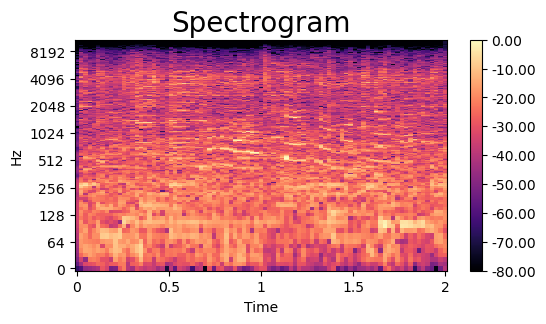

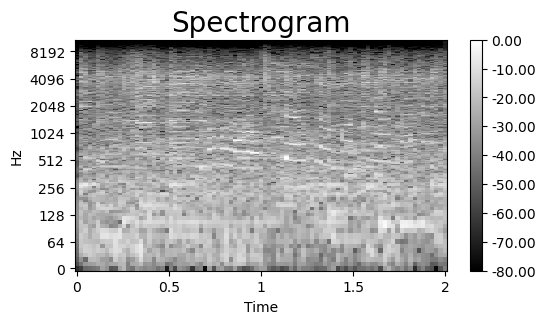

In [32]:
spectrogram = get_spectrogram(y)
figure = plot_spectrogram(spectrogram, sr, grayscale=False)
figure = plot_spectrogram(spectrogram, sr)
plt.show()

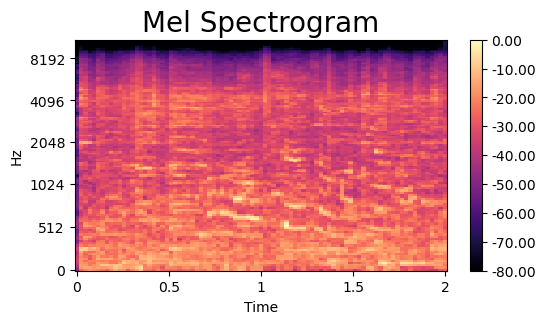

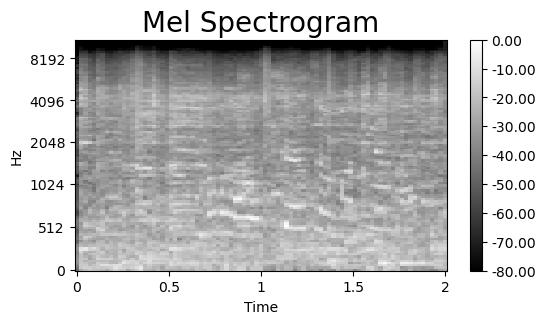

In [33]:
mel_spectrogram = get_mel_spectrogram(y, sr)
figure = plot_mel_spectrogram(mel_spectrogram, sr, grayscale=False)
figure = plot_mel_spectrogram(mel_spectrogram, sr)
plt.show()

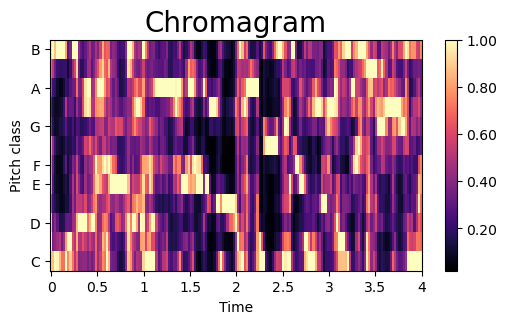

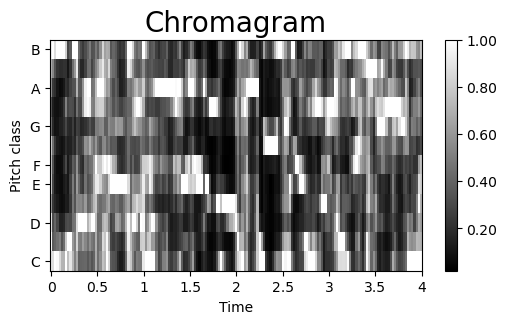

Estimated chroma keys: ['C', 'A', 'G#']


In [34]:
chroma = get_chroma(y, sr)
figure = plot_chroma(chroma, sr, grayscale=False)
figure = plot_chroma(chroma, sr)
plt.show()

top_3_chroma_keys = estimate_chroma_keys(chroma)
print(f'Estimated chroma keys: {top_3_chroma_keys}')

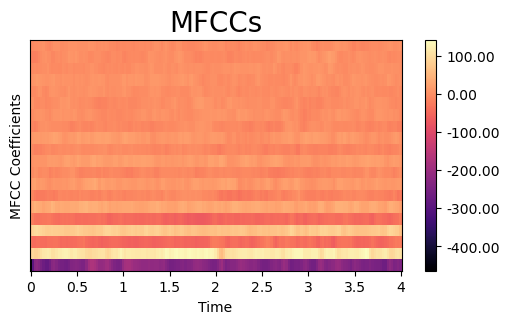

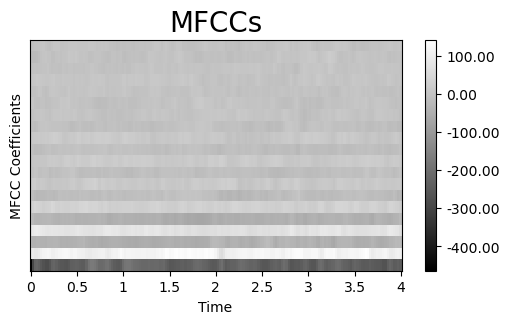

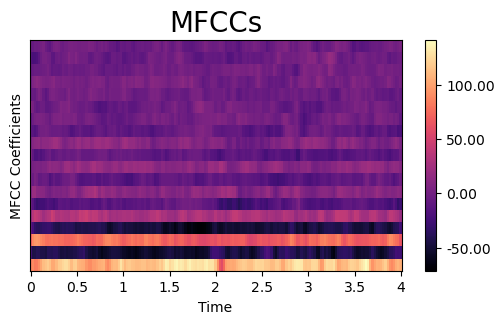

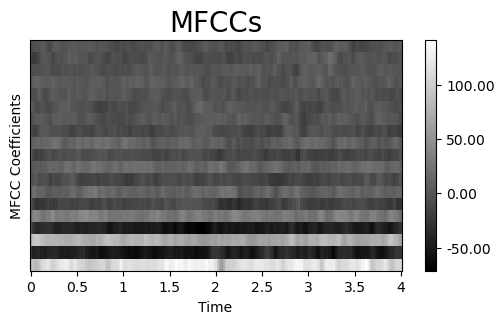

In [35]:
mfccs = get_mfccs(y, sr)
figure = plot_mfccs(mfccs, sr, grayscale=False)
figure = plot_mfccs(mfccs, sr)
plt.show()

# mfccs without first row
mfccs = np.delete(mfccs, 0, axis=0)
figure = plot_mfccs(mfccs, sr, grayscale=False)
figure = plot_mfccs(mfccs, sr)
plt.show()

In [36]:
import csv
import gc

In [37]:
project_dir = os.path.relpath(os.path.join(os.getcwd(), os.pardir))
features_dir = os.path.join(project_dir, "features")

dataset_dir = os.path.join(features_dir, DATASET_DIR)
os.makedirs(dataset_dir, exist_ok=True)

csv_file_name = "features.csv"
csv_file_path = os.path.join(dataset_dir, csv_file_name)


def get_output_file(parent_dirs, file_name, name):
    if parent_dirs != '':
        return f"{dataset_dir}\\{parent_dirs}\\{file_name}\\{name}"
    
    return f"{dataset_dir}\\{file_name}\\{name}"


def clear_fig_memory():
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()

In [38]:
num_rows = len(df)
data_list = [None] * num_rows

for index, row in df.iterrows():       
    name = row['name']
    path = row['path']    
    parent_dirs = row['dirs']

    y, sr = load_audio_from_path(path)

    output_file = get_output_file(parent_dirs, name, 'spectrogram')

    try:
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
    except Exception as e:
        print("Error creating directory:", e)

    # SPECTROGRAM
    spectrogram = get_spectrogram(y)
    path_spectrogram_img = save_spectrogram_image(spectrogram, sr, output_file)
    path_spectrogram_arr = save_numpy_array(spectrogram, output_file)
    clear_fig_memory()
    
    # MEL_SPECTROGRAM
    output_file = get_output_file(parent_dirs, name, 'mel_spectrogram')
    mel_spectrogram = get_mel_spectrogram(y, sr)
    path_mel_spectrogram_img = save_mel_spectrogram_image(mel_spectrogram, sr, output_file)
    path_mel_spectrogram_arr = save_numpy_array(mel_spectrogram, output_file)
    clear_fig_memory()
    
    # CHROMAGRAM
    output_file = get_output_file(parent_dirs, name, 'chromagram')
    chromagram = get_chroma(y, sr)
    
    top_3_chroma_keys = estimate_chroma_keys(chromagram)
    
    path_chromagram_img = save_chroma_image(chromagram, sr, output_file)
    path_chromagram_arr = save_numpy_array(chromagram, output_file)
    clear_fig_memory()
    
    # MFCCs
    output_file = get_output_file(parent_dirs, name, 'mfccs')
    mfccs = get_mfccs(y, sr)
    path_mfccs_img = save_mfccs_image(mfccs, sr, output_file)
    path_mfccs_arr = save_numpy_array(mfccs, output_file)
    clear_fig_memory()
    
    # MFCCs without first row
    output_file = get_output_file(parent_dirs, name, 'mfccs_without_0')
    mfccs = np.delete(mfccs, 0, axis=0)
    path_mfccs_without_0_img = save_mfccs_image(mfccs, sr, output_file)
    path_mfccs_without_0_arr = save_numpy_array(mfccs, output_file)
    clear_fig_memory()
    
    #TODO: change parent_dirs to actual label
    data_list[index] = {
        'name': name,
        'duration': get_duration(y, sr),
        'tempo': get_tempo(y, sr),
        'chroma_key_1': top_3_chroma_keys[0],
        'chroma_key_2': top_3_chroma_keys[1],
        'chroma_key_3': top_3_chroma_keys[2],
        'mean_root_square_mean': get_mean_root_square_mean(y),
        'mean_zero_crossing_rate': get_mean_zero_crossing_rate(y),
        'mean_spectral_centroid': get_mean_spectral_centroid(y),
        'mean_spectral_bandwith': get_mean_spectral_bandwith(y, sr),
        'mean_spectral_roll_off': get_mean_spectral_roll_off(y, sr),
        'path': path,
        'path_spectrogram_img': path_spectrogram_img,
        'path_spectrogram_arr': path_spectrogram_arr,
        'path_mel_spectrogram_img': path_mel_spectrogram_img,
        'path_mel_spectrogram_arr': path_mel_spectrogram_arr,
        'path_chromagram_img': path_chromagram_img,
        'path_chromagram_arr': path_chromagram_arr,
        'path_mfccs_img': path_mfccs_img,
        'path_mfccs_arr': path_mfccs_arr,
        'path_mfccs_without_0_img': path_mfccs_without_0_img,
        'path_mfccs_without_0_arr': path_mfccs_without_0_arr,
        'label': parent_dirs
    }
    
#     del spectrogram, mel_spectrogram, chromagram, mfccs, y, sr
    plt.close('all')
    
    if index % 50 == 0:
        print(f"Extracted features from {index} files")
        print(f"Garbage collector, released memory: {gc.collect()}")        

Extracted features from 0 files
Garbage collector, released memory: 8077


C:\Users\User\miniconda3\envs\audio\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Extracted features from 50 files
Garbage collector, released memory: 57494
Extracted features from 100 files
Garbage collector, released memory: 31777
Extracted features from 150 files
Garbage collector, released memory: 6063
Extracted features from 200 files
Garbage collector, released memory: 58622
Extracted features from 250 files
Garbage collector, released memory: 35481
Extracted features from 300 files
Garbage collector, released memory: 20320
Extracted features from 350 files
Garbage collector, released memory: 102478
Extracted features from 400 files
Garbage collector, released memory: 97137
Extracted features from 450 files
Garbage collector, released memory: 89051
Extracted features from 500 files
Garbage collector, released memory: 80965
Extracted features from 550 files
Garbage collector, released memory: 72879
Extracted features from 600 files
Garbage collector, released memory: 64793
Extracted features from 650 files
Garbage collector, released memory: 56707
Extracted fea

C:\Users\User\miniconda3\envs\audio\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


Extracted features from 1100 files
Garbage collector, released memory: 197053
Extracted features from 1150 files
Garbage collector, released memory: 197053
Extracted features from 1200 files
Garbage collector, released memory: 197053
Extracted features from 1250 files
Garbage collector, released memory: 197053
Extracted features from 1300 files
Garbage collector, released memory: 197053
Extracted features from 1350 files
Garbage collector, released memory: 197053
Extracted features from 1400 files
Garbage collector, released memory: 197053


C:\Users\User\miniconda3\envs\audio\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
C:\Users\User\miniconda3\envs\audio\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Extracted features from 1450 files
Garbage collector, released memory: 197053
Extracted features from 1500 files
Garbage collector, released memory: 197053
Extracted features from 1550 files
Garbage collector, released memory: 197053
Extracted features from 1600 files
Garbage collector, released memory: 197053
Extracted features from 1650 files
Garbage collector, released memory: 197053
Extracted features from 1700 files
Garbage collector, released memory: 197053
Extracted features from 1750 files
Garbage collector, released memory: 197053
Extracted features from 1800 files
Garbage collector, released memory: 197053
Extracted features from 1850 files
Garbage collector, released memory: 197053
Extracted features from 1900 files
Garbage collector, released memory: 197053
Extracted features from 1950 files
Garbage collector, released memory: 197053
Extracted features from 2000 files
Garbage collector, released memory: 197053
Extracted features from 2050 files
Garbage collector, released m

Extracted features from 6750 files
Garbage collector, released memory: 197053
Extracted features from 6800 files
Garbage collector, released memory: 197053
Extracted features from 6850 files
Garbage collector, released memory: 197053
Extracted features from 6900 files
Garbage collector, released memory: 197053
Extracted features from 6950 files
Garbage collector, released memory: 197053
Extracted features from 7000 files
Garbage collector, released memory: 197053
Extracted features from 7050 files
Garbage collector, released memory: 197053
Extracted features from 7100 files
Garbage collector, released memory: 197053
Extracted features from 7150 files
Garbage collector, released memory: 197053
Extracted features from 7200 files
Garbage collector, released memory: 197053
Extracted features from 7250 files
Garbage collector, released memory: 197053
Extracted features from 7300 files
Garbage collector, released memory: 197053
Extracted features from 7350 files
Garbage collector, released m

In [39]:
with open(csv_file_path, mode='w', newline='') as csv_file:
    headers = [
        'name', 'duration', 'tempo', 
        'chroma_key_1', 'chroma_key_2', 'chroma_key_3', 
        'mean_root_square_mean', 'mean_zero_crossing_rate', 
        'mean_spectral_centroid', 'mean_spectral_bandwith', 'mean_spectral_roll_off', 
        'path', 'path_spectrogram_img', 'path_spectrogram_arr', 
        'path_mel_spectrogram_img', 'path_mel_spectrogram_arr', 
        'path_chromagram_img', 'path_chromagram_arr', 
        'path_mfccs_img', 'path_mfccs_arr', 'path_mfccs_without_0_img', 'path_mfccs_without_0_arr', 
        'label'
    ]
    writer = csv.DictWriter(csv_file, fieldnames=headers)
    writer.writeheader()
    writer.writerows(data_list)

In [40]:
gc.collect()

10560827